In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle
else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict


def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
# Load the data samples
x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


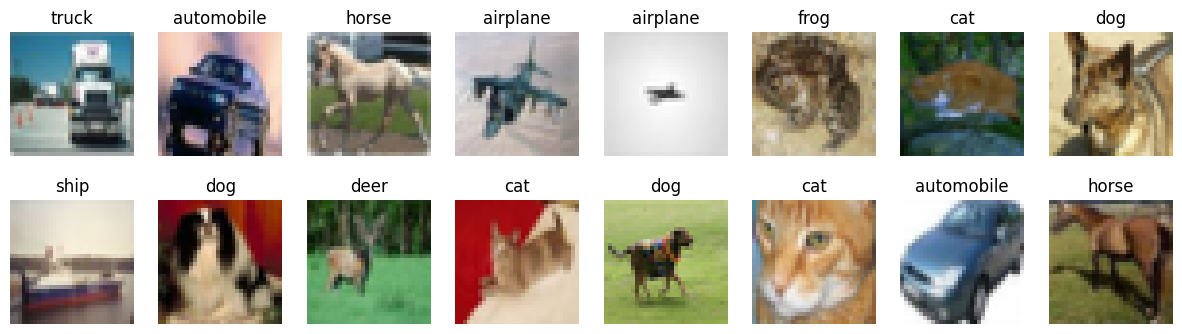

In [4]:
# show some random images from train, and their labels
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU

In [7]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000, 10)
Test samples: (10000, 32, 32, 3) (10000, 10)
Val samples: (10000, 32, 32, 3) (10000, 10)


In [11]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    ''' model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))  #get input shape from shape printed above of x_train etc
    model.add(MaxPooling2D(pool_size=(5, 5))) #condenses less in one go then 3,3 or even 2,2
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    ''' #this was my model at first following step by step. It sucked (like 0.09 accuracy that DECREASED somehow)
    #i talke to george so now im adding hella layers.

    ### --> Build your convolutional neural network.
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    # accuracy was terrible so im adding more conv and pooling layers
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.
    ### END STUDENT CODE ###

    #1st layer: 32 allows to capture simple patterns, then normalize and pool
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3,3), activation="relu", padding="Same")) #why do i put 2? comes from smrithi
    model.add(BatchNormalization())  #George (the TA) told me to do this
    model.add(MaxPooling2D(pool_size=(2, 2))) # Less aggressive pooling
    model.add(BatchNormalization()) #2nd normalization after pooling

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))  # Prevent overfitting

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #Output Layer (10 classes)
    model.add(Dense(10))
    # Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax"))

    return model

In [12]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 100


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2554 - loss: 2.2287 - val_accuracy: 0.3786 - val_loss: 1.7073
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5175 - loss: 1.3505 - val_accuracy: 0.5530 - val_loss: 1.2304
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6411 - loss: 1.0354 - val_accuracy: 0.6858 - val_loss: 0.8870
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7235 - loss: 0.8122 - val_accuracy: 0.6893 - val_loss: 0.9016
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7593 - loss: 0.7268 - val_accuracy: 0.6723 - val_loss: 0.9727
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7865 - loss: 0.6431 - val_accuracy: 0.7168 - val_loss: 0.8377
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8144 - loss: 0.5589 - val_accuracy: 0.7037 - val_loss: 0.9156
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8474 

In [13]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


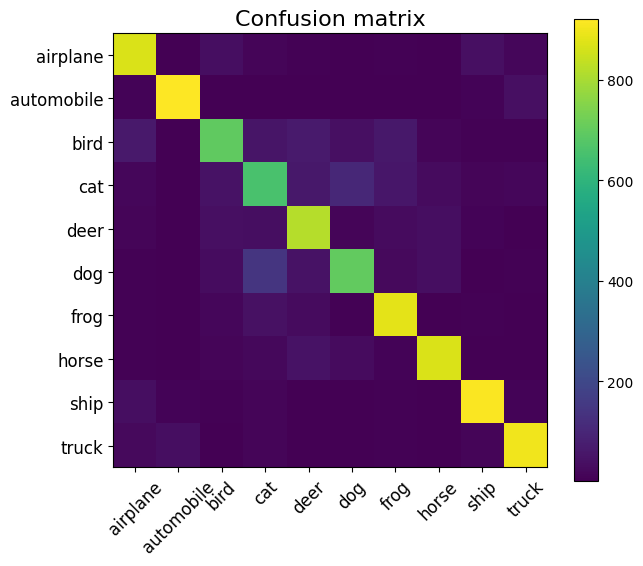

Test accuracy: 0.822


In [14]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

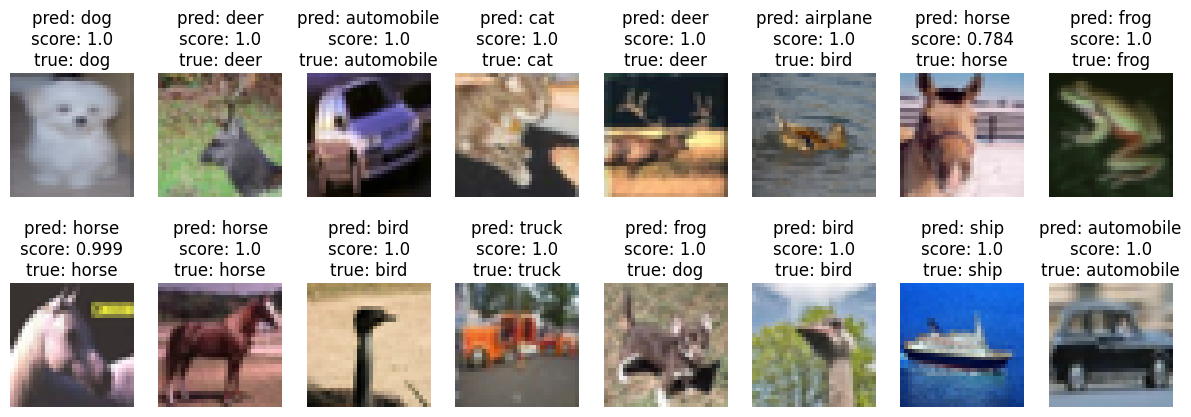

In [15]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


